# HybridSN 高光谱分类  
首先取得数据，并引入基本函数库。

In [1]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

--2020-08-11 14:36:46--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  1.64MB/s    in 3.8s    

2020-08-11 14:36:50 (1.49 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-08-11 14:36:54--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-08-11 14:36:54 (197 MB/s) - ‘Indian_pines_gt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 定义 HybridSN 类  
![alt text](https://camo.githubusercontent.com/f7db2d6ed93212a9b4d31c2826e38a2bdd964311/68747470733a2f2f67616f707572737569742e6f73732d636e2d6265696a696e672e616c6979756e63732e636f6d2f3230323030332f32303230303330343230333731302e6a7067)  

三维卷积部分：

conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==>  （8, 24, 23, 23）  
conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）  
conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）  
接下来要进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）  

二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）

接下来是一个 flatten 操作，变为 18496 维的向量，

接下来依次为256，128节点的全连接层，都使用比例为0.4的 Dropout，

最后输出为 16 个节点，是最终的分类类别数。

下面是 HybridSN 类的代码：

In [ ]:
# 原始代码
class_num = 16

class HybridSN(nn.Module):

  def __init__(self):
    super(HybridSN, self).__init__()
	# 3个3D卷积
    # conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==> （8, 24, 23, 23）
    self.conv1_3d = nn.Sequential(
        nn.Conv3d(1,8,(7,3,3)),
        nn.BatchNorm3d(8),
        nn.ReLU()
    )
	# conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）
    self.conv2_3d = nn.Sequential(
        nn.Conv3d(8,16,(5,3,3)),
        nn.BatchNorm3d(16),
        nn.ReLU()
    )
	# conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）
    self.conv3_3d = nn.Sequential(
        nn.Conv3d(16,32,(3,3,3)),
        nn.BatchNorm3d(32),
        nn.ReLU()
    )
	# 二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）
    self.conv4_2d = nn.Sequential(
        nn.Conv2d(576,64,(3,3)),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
	# 接下来依次为256，128节点的全连接层，都使用比例为0.1的 Dropout
    self.fn1 = nn.Linear(18496,256)
    self.fn2 = nn.Linear(256,128)

    self.fn_out = nn.Linear(128,class_num)

    self.drop = nn.Dropout(p = 0.1)
    # emm我在这里使用了softmax之后，网络在训练过程中loss就不再下降了，不知道具体是为啥，很奇怪，，
    # self.soft = nn.Softmax(dim = 1)

  def forward(self, x):
    out = self.conv1_3d(x)
    out = self.conv2_3d(out)
    out = self.conv3_3d(out)
	# 进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）
    b,x,y,m,n = out.size()
    out = out.view(b,x*y,m,n)

    out = self.conv4_2d(out)
	# 接下来是一个 flatten 操作，变为 18496 维的向量
    # 进行重组，以b行，d列的形式存放（d自动计算）
    out = out.reshape(b,-1)

    out = self.fn1(out)
    out = self.drop(out)
    out = self.fn2(out)
    out = self.drop(out)

    out = self.fn_out(out)

    # out = self.soft(out)

    return out

# 随机输入，测试网络结构是否通
x = torch.randn(1, 1, 30, 25, 25)
net = HybridSN()
y = net(x)
print(y.shape)
print(y)

torch.Size([1, 16])
tensor([[ 0.1285,  0.3525, -0.0756,  0.0151, -0.0222,  0.0053,  0.1639,  0.2420,
          0.0098, -0.0929, -0.1854, -0.0890,  0.0499,  0.1919,  0.1547, -0.1718]],
       grad_fn=<AddmmBackward>)


In [3]:
# 模型改进——先使用二位卷积，在使用三位卷积
class_num = 16

class HybridSN(nn.Module):

  def __init__(self):
    super(HybridSN, self).__init__()
	# 二维卷积：原始输入（30, 25, 25） 64个 3x3x30 的卷积核，得到 （64, 23, 23）
    self.conv4_2d = nn.Sequential(
        nn.Conv2d(30,64,(3,3)),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    # 三个三维卷积
    # conv1：（1, 64, 23, 23）， 8个 7x3x3 的卷积核 ==> （8, 58, 21, 21）
    self.conv1_3d = nn.Sequential(
        nn.Conv3d(1,8,(7,3,3)),
        nn.BatchNorm3d(8),
        nn.ReLU()
    )
    # conv2：（8, 58, 21, 21）， 16个 5x3x3 的卷积核 ==> （16, 54, 19, 19）
    self.conv2_3d = nn.Sequential(
        nn.Conv3d(8,16,(5,3,3)),
        nn.BatchNorm3d(16),
        nn.ReLU()
    )
    # conv3：（16, 54, 19, 19）， 32个 5x3x3 的卷积核 ==> （32, 52, 17, 17）
    self.conv3_3d = nn.Sequential(
        nn.Conv3d(16,32,(3,3,3)),
        nn.BatchNorm3d(32),
        nn.ReLU()
    )

    self.fn1 = nn.Linear(480896,256)# 32*52*17*17
    self.fn2 = nn.Linear(256,128)

    self.fn_out = nn.Linear(128,class_num)

    self.drop = nn.Dropout(p = 0.4)
    # emm我在这里使用了softmax之后，网络在训练过程中loss就不再下降了，不知道具体是为啥，很奇怪，，
    # self.soft = nn.Softmax(dim = 1)

  def forward(self, x):
    # 先降到二维
    out = x.view(x.shape[0],x.shape[2],x.shape[3],x.shape[4])
    out = self.conv4_2d(out)
    # 增加一个维度（64, 23, 23）-->（1,64, 23, 23）
    out = out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])

    out = self.conv1_3d(out)
    out = self.conv2_3d(out)
    out = self.conv3_3d(out)
    # 进行重组，以b行，d列的形式存放（d自动计算）
    out = out.view(out.shape[0],-1)

    out = self.fn1(out)
    out = self.drop(out)
    out = self.fn2(out)
    out = self.drop(out)

    out = self.fn_out(out)

    return out

# 随机输入，测试网络结构是否通
x = torch.randn(1,1, 30, 25, 25)
net = HybridSN()
y = net(x)
print(y.shape)
print(y)

torch.Size([1, 16])
tensor([[-0.0244, -0.3607, -0.0801,  0.2004, -0.1874, -0.1941, -0.0395,  0.1199,
         -0.1129,  0.0493,  0.0176, -0.0850,  0.1632,  0.3491,  0.2695,  0.0121]],
       grad_fn=<AddmmBackward>)


In [44]:
# 引入注意力机制
class_num = 16


class Attention_Block(nn.Module):

    def __init__(self, planes, size):
        super(Attention_Block, self).__init__()

        self.globalAvgPool = nn.AvgPool2d(size, stride=1)

        self.fc1 = nn.Linear(planes, round(planes / 16))
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(round(planes / 16), planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.globalAvgPool(x)
        out = out.view(out.shape[0], out.shape[1])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        out = out.view(out.shape[0], out.shape[1], 1, 1)
        out = out * residual

        return out



class HybridSN(nn.Module):

    def __init__(self):
        super(HybridSN, self).__init__()
        # 3个3D卷积
        # conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==> （8, 24, 23, 23）
        self.conv1_3d = nn.Sequential(
            nn.Conv3d(1,8,(7,3,3)),
            nn.BatchNorm3d(8),
            nn.ReLU()
        )
        # conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）
        self.conv2_3d = nn.Sequential(
            nn.Conv3d(8,16,(5,3,3)),
            nn.BatchNorm3d(16),
            nn.ReLU()
        )
        # conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）
        self.conv3_3d = nn.Sequential(
            nn.Conv3d(16,32,(3,3,3)),
            nn.BatchNorm3d(32),
            nn.ReLU()
        )
        # 二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）
        self.conv4_2d = nn.Sequential(
            nn.Conv2d(576,64,(3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # 注意力机制部分
        self.layer1 = self.make_layer(Attention_Block,planes = 576, size = 19)
        self.layer2 = self.make_layer(Attention_Block,planes = 64, size = 17)

        # 接下来依次为256，128节点的全连接层，都使用比例为0.1的 Dropout
        self.fn1 = nn.Linear(18496,256)
        self.fn2 = nn.Linear(256,128)

        self.fn_out = nn.Linear(128,class_num)

        self.drop = nn.Dropout(p = 0.1)
        # emm我在这里使用了softmax之后，网络在训练过程中loss就不再下降了，不知道具体是为啥，很奇怪，，
        # self.soft = nn.Softmax(dim = 1)

    def make_layer(self, block, planes, size):
        layers = []
        layers.append(block(planes, size))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1_3d(x)
        out = self.conv2_3d(out)
        out = self.conv3_3d(out)
        # 进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）
        out = out.view(out.shape[0],out.shape[1]*out.shape[2],out.shape[3],out.shape[4])

        # 在二维卷积部分引入注意力机制
        out = self.layer1(out)
        out = self.conv4_2d(out)
        out = self.layer2(out)
        # 接下来是一个 flatten 操作，变为 18496 维的向量
        # 进行重组，以b行，d列的形式存放（d自动计算）
        out = out.view(out.shape[0],-1)

        out = self.fn1(out)
        out = self.drop(out)
        out = self.fn2(out)
        out = self.drop(out)

        out = self.fn_out(out)

        # out = self.soft(out)

        return out

# 随机输入，测试网络结构是否通
x = torch.randn(1, 1, 30, 25, 25)
net = HybridSN()
y = net(x)
print(y.shape)
print(y)

torch.Size([1, 16])
tensor([[ 0.2083, -0.0485, -0.0676,  0.1078,  0.0107,  0.0828,  0.0422, -0.0309,
          0.0706, -0.0167, -0.1339, -0.0660, -0.1316,  0.0684, -0.1107, -0.0173]],
       grad_fn=<AddmmBackward>)


## 创建数据集
首先对高光谱数据实施PCA降维；然后创建 keras 方便处理的数据格式；然后随机抽取 10% 数据做为训练集，剩余的做为测试集。

首先定义基本函数：

In [4]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

下面读取并创建数据集：

In [5]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


## 开始训练

In [45]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
net.train()
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')

[Epoch: 1]   [loss avg: 30.1527]   [current loss: 2.3643]
[Epoch: 2]   [loss avg: 20.2693]   [current loss: 0.8725]
[Epoch: 3]   [loss avg: 15.3539]   [current loss: 0.5051]
[Epoch: 4]   [loss avg: 12.2506]   [current loss: 0.2793]
[Epoch: 5]   [loss avg: 10.0476]   [current loss: 0.1493]
[Epoch: 6]   [loss avg: 8.4768]   [current loss: 0.0752]
[Epoch: 7]   [loss avg: 7.3092]   [current loss: 0.0210]
[Epoch: 8]   [loss avg: 6.4156]   [current loss: 0.0077]
[Epoch: 9]   [loss avg: 5.7171]   [current loss: 0.0052]
[Epoch: 10]   [loss avg: 5.1532]   [current loss: 0.0050]
[Epoch: 11]   [loss avg: 4.6892]   [current loss: 0.0027]
[Epoch: 12]   [loss avg: 4.3027]   [current loss: 0.0020]
[Epoch: 13]   [loss avg: 3.9752]   [current loss: 0.0155]
[Epoch: 14]   [loss avg: 3.6932]   [current loss: 0.0020]
[Epoch: 15]   [loss avg: 3.4484]   [current loss: 0.0042]
[Epoch: 16]   [loss avg: 3.2341]   [current loss: 0.0016]
[Epoch: 17]   [loss avg: 3.0448]   [current loss: 0.0021]
[Epoch: 18]   [los

## 模型测试

In [47]:
count = 0
# 模型测试

net.eval()
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.9535    1.0000    0.9762        41
         1.0     0.9959    0.9541    0.9746      1285
         2.0     0.9920    1.0000    0.9960       747
         3.0     1.0000    0.9812    0.9905       213
         4.0     0.9977    0.9977    0.9977       435
         5.0     0.9894    0.9909    0.9901       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    1.0000    1.0000       430
         8.0     1.0000    0.8889    0.9412        18
         9.0     0.9920    0.9943    0.9932       875
        10.0     0.9774    0.9973    0.9872      2210
        11.0     0.9888    0.9906    0.9897       534
        12.0     1.0000    1.0000    1.0000       185
        13.0     0.9939    1.0000    0.9969      1139
        14.0     1.0000    1.0000    1.0000       347
        15.0     0.9750    0.9286    0.9512        84

    accuracy                         0.9898      9225
   macro avg     0.9910   

## 备用函数

In [ ]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred =  outputs
            count = 1
        else:
            y_pred = np.concatenate( (y_pred, outputs) )

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

检测结果写在文件里：

In [ ]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

下面代码用于显示分类结果：

In [ ]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


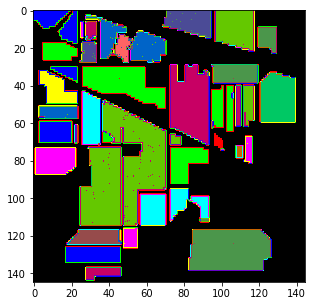

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))